# Random Forest Baseline - LB 0.664

랜덤 포레스트로 18개 질문 각각에 대해 그룹 KFold 모델을 교육합니다.  
CV 점수는 0.664이고 KFold 모델 중 하나를 사용하여 테스트를 추론합니다.   
랜덤 포레스트를 위해 더 많은 기능을 엔지니어링하거나 다른 모델(다른 ML 모델 및/또는 RNN 및/또는 Transformer)을   
시도하여 CV 및 LB를 개선할 수 있습니다. 또한 더 많은 KFold 모델을 사용하거나 모든 데이터(및 KFold 교차 검증에서  
발견한 하이퍼 파라미터)를 사용하여 하나의 모델을 교육하여 LB를 개선할 수 있습니다.  

In [2]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Load Train Data and Labels

In [3]:
train = pd.read_csv('/Users/leebyeongho/Downloads/predict-student-performance-from-game-play/train.csv')
print(train.shape)
train.head()

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [16]:
pd.options.display.float_format = '{:.3f}'.format

In [17]:
train.describe()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
count,13174211.000,13174211.000,13174211.000,13174211.000,284746.000,12137971.000,12137971.000,12137971.000,12137971.000,1000737.000,0.000,0.000,0.000
mean,21134134855323904.000,652.643,3846817.286,12.192,3.158,-54.936,-116.300,458.114,385.236,3186.237,NaN,NaN,NaN
std,566522042999678.875,627.582,27013866.525,6.499,2.064,520.147,218.591,247.214,129.288,369226.547,NaN,NaN,NaN
min,20090312431273200.000,0.000,0.000,0.000,0.000,-1992.355,-918.159,0.000,0.000,0.000,NaN,NaN,NaN
25%,21010310162137956.000,289.000,439430.000,6.000,1.000,-352.938,-212.836,269.000,304.000,100.000,NaN,NaN,NaN
50%,21040215432620068.000,596.000,1013425.000,13.000,3.000,-11.163,-97.782,447.000,397.000,418.000,NaN,NaN,NaN
75%,21100514325903272.000,897.000,1740050.000,18.000,5.000,296.362,22.685,663.000,471.000,1266.000,NaN,NaN,NaN
max,22100221145014656.000,20473.000,1749293395.000,22.000,6.000,1261.774,543.616,1916.000,1439.000,219907810.000,NaN,NaN,NaN


In [4]:
targets = pd.read_csv('/Users/leebyeongho/Downloads/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Columns

session_id - 이벤트가 발생한 세션의 ID  
index - 세션의 이벤트 인덱스  
elapsed_time - 세션 시작과 이벤트가 기록된 시간 사이에 경과된 시간(in milliseconds)  
event_name - 이벤트 유형의 이름  
name - 이벤트 이름(예: notebook_click이 노트북을 열거나 닫는 중인지 식별)  
level - 이벤트가 발생한 게임의 레벨(0~22)  
page - 이벤트의 페이지 번호(노트북 관련 이벤트에만 해당)  
room_coor_x - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
room_coor_y - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_x - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_y - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
hover_duration - 호버가 발생한 시간(in milliseconds)(호버 이벤트에만 해당)  
text - 이 이벤트 동안 플레이어에게 표시되는 텍스트  
fqid - 이벤트의 완전한 ID  
room_fqid - 이벤트가 발생한 방의 정규화된 ID  
text_fqid - 정규화된 ID  
fullscreen - 플레이어가 전체 화면 모드인지 여부  
hq - 게임이 고품질인지 여부  
음악 - 게임 음악이 켜져 있는지 여부  
level_group - 레벨 그룹 및 질문 그룹 - 이 행은 (0-4, 5-12, 13-22)에 속합니다.  

# Feature Engineer

기본적인 Aggregate 기능을 만듭니다. CV와 LB를 강화하기 위해 더 많은 기능을 만들어 보십시오!

In [5]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

## CATS     

event_name - 이벤트 유형의 이름  
name - 이벤트 이름(예: notebook_click이 노트북을 열거나 닫는 중인지 식별)  
fqid - 이벤트의 완전한 ID  
room_fqid - 이벤트가 발생한 방의 정규화된 ID  
text_fqid - 정규화된 ID  

## NUMS  

elapsed_time - 세션 시작과 이벤트가 기록된 시간 사이에 경과된 시간(밀리초)  
level - 이벤트가 발생한 게임의 레벨(0~22)  
page - 이벤트의 페이지 번호(노트북 관련 이벤트에만 해당)  
room_coor_x - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
room_coor_y - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_x - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_y - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
hover_duration - 호버가 발생한 시간(밀리초)(호버 이벤트에만 해당)  

## 안 쓴 특성   
index - 세션의 이벤트 인덱스  
text - 이 이벤트 동안 플레이어에게 표시되는 텍스트  
fullscreen - 플레이어가 전체 화면 모드인지 여부  
hq - 게임이 고품질인지 여부  
음악 - 게임 음악이 켜져 있는지 여부  

## feature_engineer
level_group - 레벨 그룹 및 질문 그룹 - 이 행은 (0-4, 5-12, 13-22)에 속합니다.  
session_id - 이벤트가 발생한 세션의 ID  

In [6]:
def feature_engineer(train):
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [7]:
%%time
df = feature_engineer(train)
print(df.shape)
df.head()

(35337, 22)
CPU times: user 18.2 s, sys: 641 ms, total: 18.8 s
Wall time: 19 s


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044872,2389.500000,49246.539458,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347170,...,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784906,969.333333,80175.676658,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045960,...,370.723077,1378.750000,67372.714092,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762282,...,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


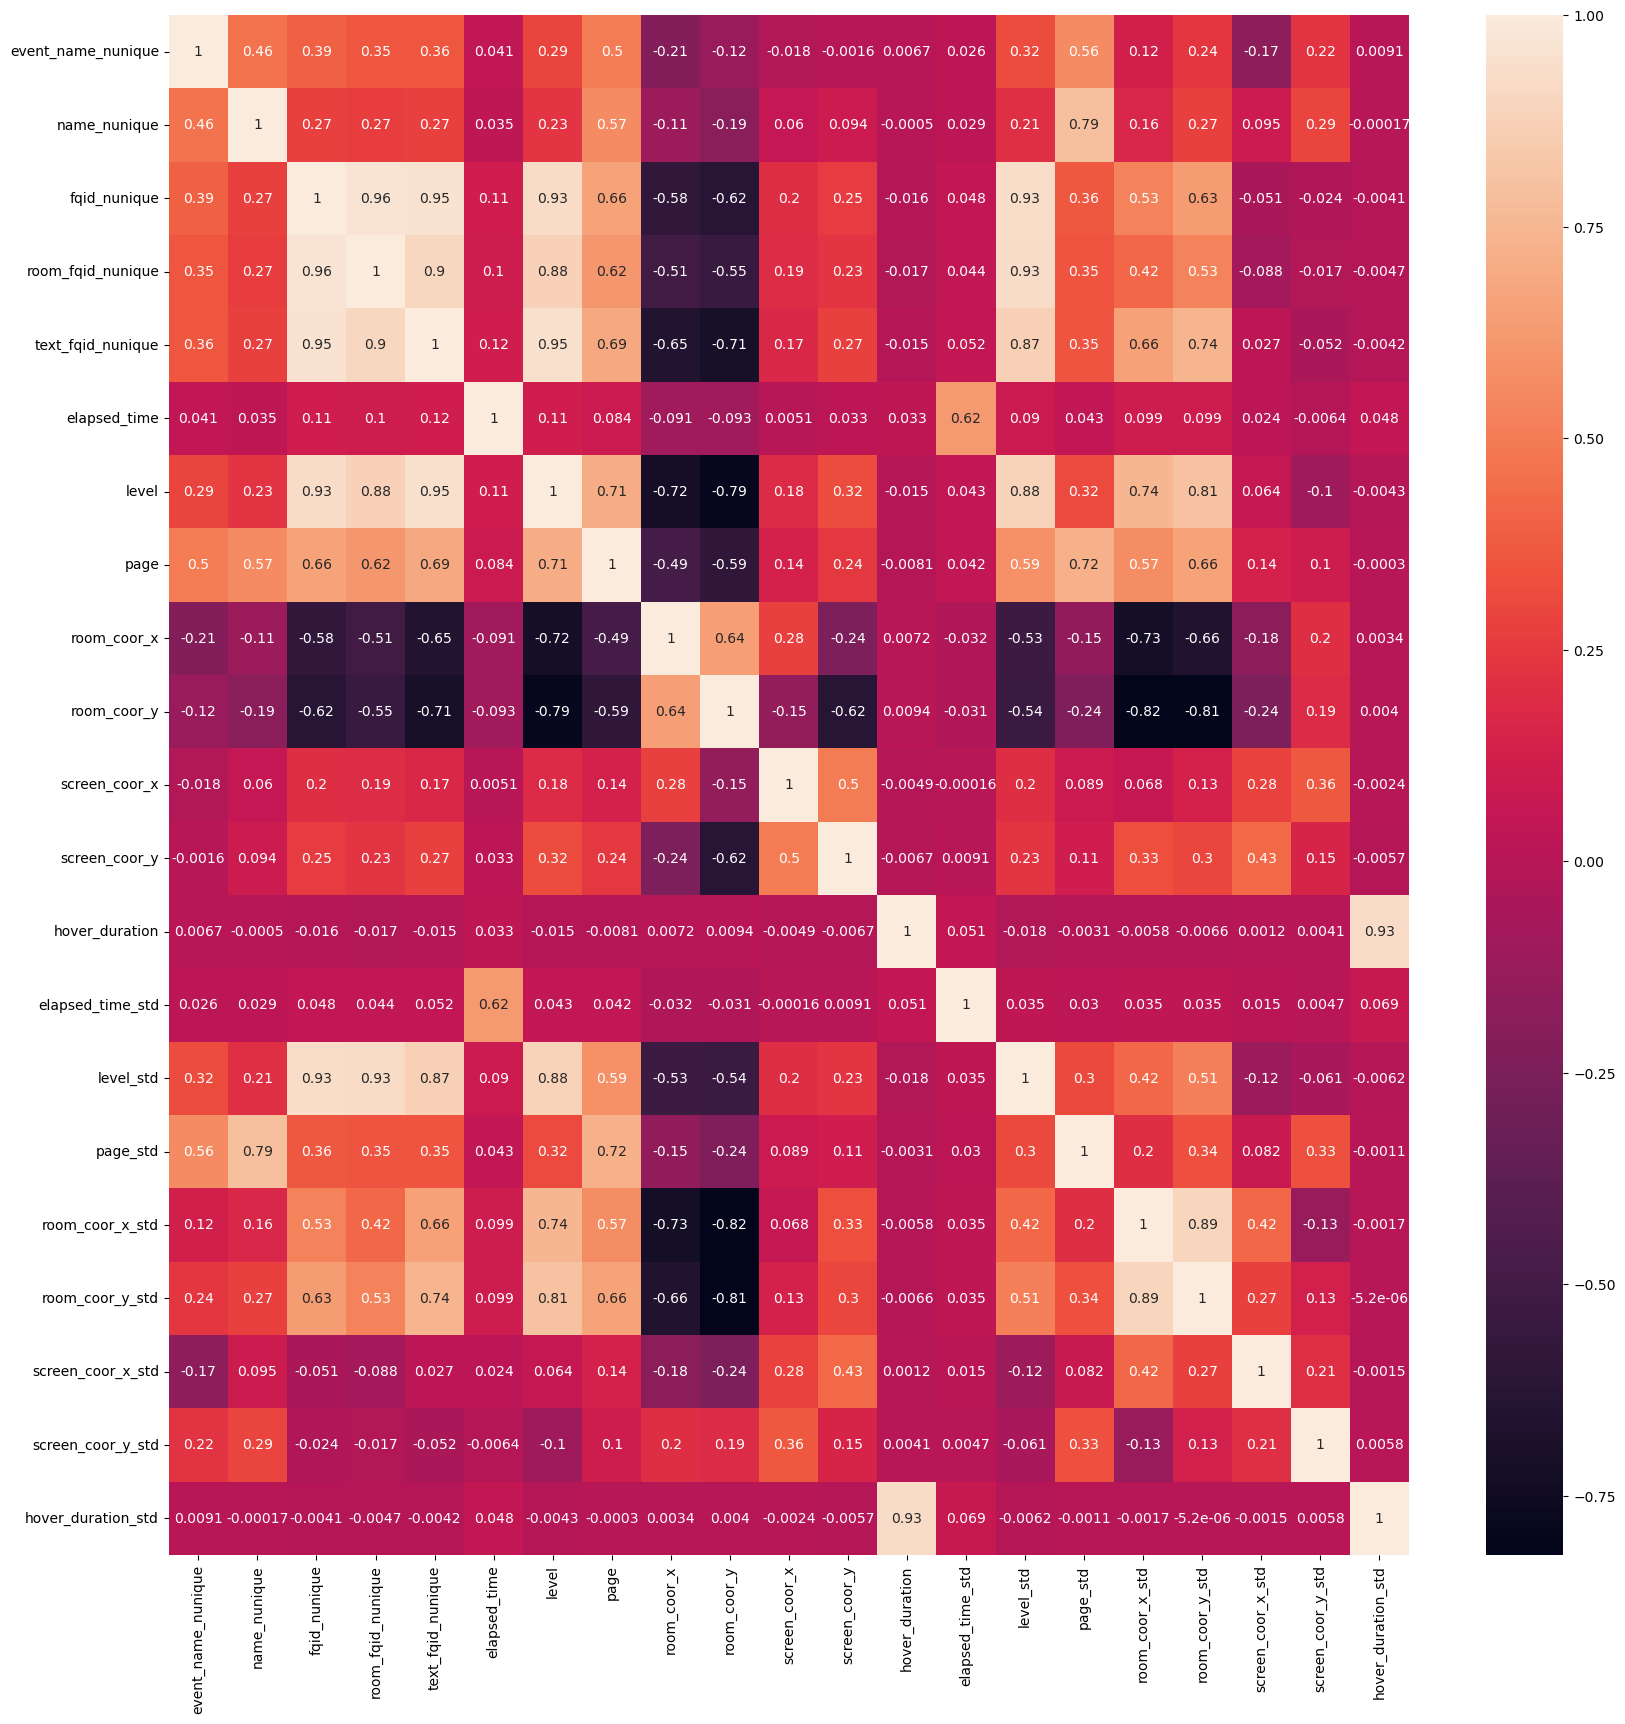

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
features = df.columns
corr_df = df[features].corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_df, annot=True);

# Train Random Forest Model

우리는 18개의 질문 각각에 대해 하나의 모델을 훈련시킨다.  
또한, 우리는 level_groups = '0-4'의 데이터를 사용하여 질문 1-3에 대한 모델을 훈련하고,  
질문 4-13에 대한 레벨 그룹 '5-12'와 질문 14-18에 대한 레벨 그룹 '13-22'를 사용한다.  
왜냐하면 이것은 테스트 추론 중에 카글의 추론 API로부터 우리가 (해당 질문을 예측하기 위해)  
얻는 데이터이기 때문이다. 이전 level_groups에서 사용자의 이전 데이터를 저장하고  
이를 사용하여 미래 level_groups를 예측함으로써 모델을 개선할 수 있다.

In [9]:
FEATURES = df.columns[1:]
print(f'{len(FEATURES)}개의 특성')
ALL_USERS = df.index.unique()
print(f'{len(ALL_USERS)}명의 유저 정보')

21개의 특성
11779명의 유저 정보


In [10]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# GroupKFold 5개로 CV 점수를 계산합니다
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('')
    print('Fold',i+1)
    print('')
    
    # 질문 1부터 18까지 반복합니다
    for t in range(1,19):
        print(t,', ',end='')
        
        # train data를 다음 질문과 함께 사용하십시오
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # train data
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        test_x = df.iloc[test_index]
        test_x = test_x.loc[test_x.level_group == grp]
        test_users = test_x.index.values
        test_y = targets.loc[targets.q==t].set_index('session').loc[test_users]
        
        # RandomForest모델
        clf = RandomForestClassifier() 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # 모델을 저장하고 예측수행
        models[f'{grp}_{t}'] = clf
        oof.loc[test_users, t-1] = clf.predict_proba(test_x[FEATURES].astype('float32'))[:,1]
        
    print()


Fold 1

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 

Fold 2

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 

Fold 3

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 

Fold 4

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 

Fold 5

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


# Compute CV Score

예측 확률을 1과 0으로 변환해야 합니다. 경기 측정 기준은 정밀도와 리콜의 조화 평균인 F1 점수입니다. 
1을 예측할 때 p > 임계값에 대한 최적의 임계값과 F1 점수를 최대화하기 위해 0을 예측할 때의 임계값을 알아보겠습니다.

In [11]:
# True 레이블을 18개의 열로 구성된 데이터 프레임에 넣습니다
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [12]:
# 확률을 1과 0으로 변환하기 위한 최적의 임계값을 찾습니다
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
print(f'Best 임계점: {best_threshold:.2f}')
print(f'Best F1_score: {best_score:.4f}')

Best 임계점: 0.60
Best F1_score: 0.6646


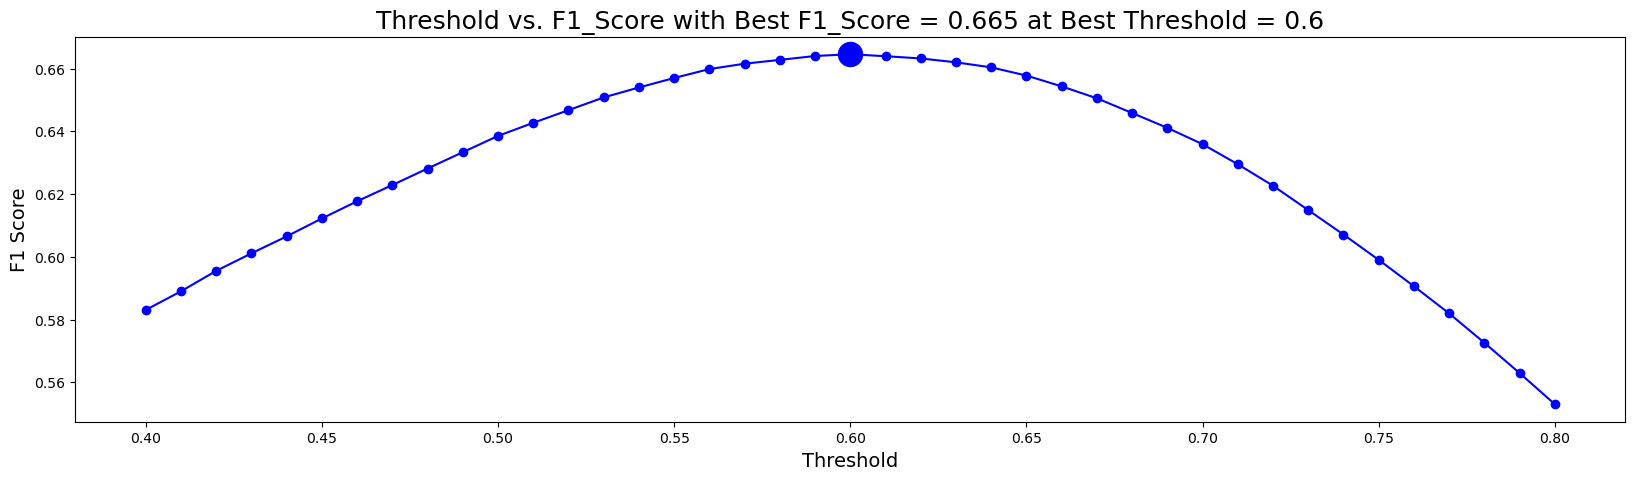

In [13]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [14]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5474269814208697
Q1: F1 = 0.4945936668669012
Q2: F1 = 0.488195413316459
Q3: F1 = 0.5782001367271049
Q4: F1 = 0.5581398722962441
Q5: F1 = 0.5878683114113147
Q6: F1 = 0.5727038849567949
Q7: F1 = 0.5363989192363937
Q8: F1 = 0.5826831770476606
Q9: F1 = 0.5179890062629727
Q10: F1 = 0.5709632860623567
Q11: F1 = 0.49062044726289167
Q12: F1 = 0.4352918663400349
Q13: F1 = 0.5883227783137263
Q14: F1 = 0.5017220708968282
Q15: F1 = 0.48343679104650533
Q16: F1 = 0.5252765953885181
Q17: F1 = 0.48897013099325226
==> Overall F1 = 0.6645945314823283
